### `Note`

In order to make training of SNN and finetuning of BERT more efficient, this notebook is meant to be run in Google Colab to utilize the available GPU there. 

To train, upload the directory of this notebook - this will contain the relevant modules and data.

Additionally, if one is only seeking to evaluate the trained models, go to the notebooks `BERT_eval.ipynb` and `SNN_eval.ipynb` to explore model performance.

***Note***\
*Due to the immense size of tf-idf embedding on corpus, the trainable params became to immense for any available device, thus training on these are not possible*


In [ ]:
# Mounting drive in colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Can't mount Google drive")

Mounted at /content/drive


# Setup

In [ ]:
!pip install datasets
!pip install transformers

In [10]:
# Data
import pandas as pd
import numpy as np
from modules.utils import SentimentDataset, w2v
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Visualization
import matplotlib.pyplot as plt

# Models
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
import tensorflow as tf
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

# General
import os
import multiprocessing
import time
import datetime
import random



In [ ]:
# Download necessary NLTK packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
# Change directory to NLP folder, which contains module and data folder. 
%cd /content/drive/MyDrive/NLP

/content/drive/MyDrive/NLP


### Importing data and applying Word2Vec

In [2]:
# Load data using SentimentDataset class
data = SentimentDataset()
w2v(data)

Loading data...


Found cached dataset sentiment140 (/Users/krebs/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)



Loading processed dataset from cache...
Dataset loaded
Applying Word2Vec embedding
Loading Word2Vec model from directory
Vectorizing range(0, 200000) tweets
Word2Vec embedding applied


In [3]:
# Printing differences
for index, row in data.df.sample(5).iterrows():
    print(f'Before processing: {row.text}\nAfter processing: {row.text_processed}\n')

Before processing: @MussoMitchel LOVED you on Radio Disney yesterday!!!!! 
After processing: loved you on radio disney yesterday

Before processing: Oh god...off to the airport...way too f'ing early...or late 
After processing: oh god off to the airport way too f ing early or late

Before processing: I'm stuck on Soviet intolerance of diversity   What were they intolerant of???
After processing: i m stuck on soviet intolerance of diversity what were they intolerant of

Before processing: @unwoman w00t! awesome! btw, thoroughly enjoyed Blossoms and just ordered Trouble... 
After processing: w00t awesome btw thoroughly enjoyed blossom and just ordered trouble

Before processing: @edinburghblog The Sheep's Heid is nowhere near as good as it used to be 
After processing: the sheep s heid is nowhere near a good a it used to be



In [4]:
print('Null values in dataset after processing')
data.df.isna().sum()

Null values in dataset after processing


text              0
sentiment         0
text_processed    0
dtype: int64

# Shallow Neural Network

In [7]:
# Splitting to have a small test set after training
X_train, X_test, y_train, y_test = train_test_split(data.vector, data.target, test_size=0.1)


In [9]:
print(f'Length of training set: {len(X_train)}')
print(f'Length of test set: {len(X_test)}')

Length of training set: 180000
Length of test set: 20000


In [ ]:
# Building neural network
model = Sequential((
    layers.Dense(250, activation = "relu", input_dim=300),
    layers.Dropout(0.3),
    layers.Dense(250, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(250, activation = "relu"),
    layers.Dense(1, activation = 'sigmoid')
))


# Creating Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5,verbose=1, min_lr=0.001)
    ]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              loss= tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

In [ ]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/100
4500/4500 [==============================] - 23s 4ms/step - loss: 0.5571 - accuracy: 0.7157 - val_loss: 0.5483 - val_accuracy: 0.7174 - lr: 0.0100
Epoch 2/100
4500/4500 [==============================] - 17s 4ms/step - loss: 0.5405 - accuracy: 0.7292 - val_loss: 0.5315 - val_accuracy: 0.7386 - lr: 0.0100
Epoch 3/100
4500/4500 [==============================] - 17s 4ms/step - loss: 0.5375 - accuracy: 0.7322 - val_loss: 0.5244 - val_accuracy: 0.7385 - lr: 0.0100
Epoch 4/100
4500/4500 [==============================] - 16s 4ms/step - loss: 0.5337 - accuracy: 0.7345 - val_loss: 0.5235 - val_accuracy: 0.7361 - lr: 0.0100
Epoch 5/100
4500/4500 [==============================] - 17s 4ms/step - loss: 0.5294 - accuracy: 0.7375 - val_loss: 0.5200 - val_accuracy: 0.7411 - lr: 0.0100
Epoch 6/100
4500/4500 [==============================] - 16s 4ms/step - loss: 0.5260 - accuracy: 0.7399 - val_loss: 0.5209 - val_accuracy: 0.7386 - lr: 0.0100
Epoch 7/100
4500/4500 [=======================

In [ ]:
# Save model in order to evaluate (Will be performed on local device. See file SNN_eval notebook in directory)
model.save(f'ShallowNeuralNetwork')

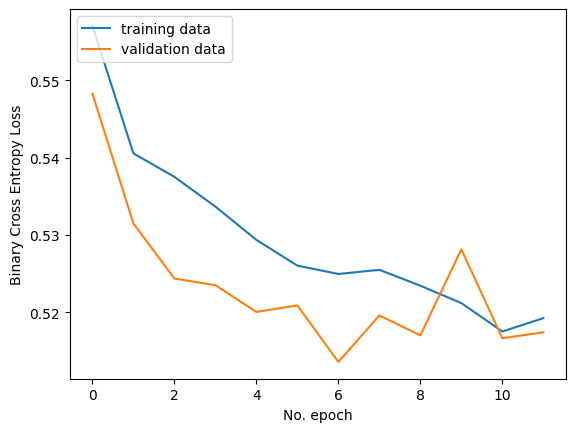

In [ ]:
# Plot Performance
plt.plot(model.history.history['loss'], label='training data')
plt.plot(model.history.history['val_loss'], label='validation data')
plt.ylabel('Binary Cross Entropy Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

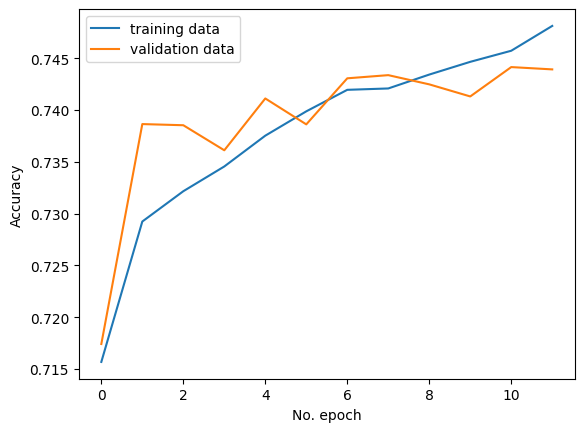

In [ ]:
# Plot Performance
plt.plot(model.history.history['accuracy'], label='training data')
plt.plot(model.history.history['val_accuracy'], label='validation data')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Fine tuning BERT

In [11]:
# Device variable to sent models and data to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
# Fetch tokenizer and Bert classification model from pre-trained library
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
# Extract sentences and labels from data
sentences = data.df.text_processed.to_list()
label = data.df.sentiment.to_list()

max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Output max length
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  65


In [14]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []


for sent in sentences:
    # Applying encode plus to every sentence
    encoded_dict = tokenizer.encode_plus(
                        sent, 
                        add_special_tokens = True, # Add sentence level classification and and sentence seperate tokens 
                        max_length = 70,           # Padding slightly larger than max sentence
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Append encoded sentences to input ids list
    input_ids.append(encoded_dict['input_ids'])
    
    # Append attention masks attention masks list. Helps differentiates padding from non-padding
    attention_masks.append(encoded_dict['attention_mask'])

# Convert all lists into pytorch tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(label)

# Print sentence and corresponding token ids
print('Sentence ', sentences[0])
print('Bert Tokenizer Token IDs', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Sentence  awww that s a bummer you shoulda got david carr of third day to do it
Bert Tokenizer Token IDs tensor([  101, 22091,  2860,  2860,  2008,  1055,  1037, 26352,  5017,  2017,
         2323,  2050,  2288,  2585, 12385,  1997,  2353,  2154,  2000,  2079,
         2009,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [ ]:
# Create Pytorch Dataset from tokenizers
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calculate the size for each subset (80/20)
train_size = int(len(dataset)*0.8) 
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

160,000 training samples
40,000 validation samples


In [ ]:
# Create Pytorch Data loader used for finetuning Bert in batches
train_dataloader = DataLoader(
            train_dataset,  # The training samples
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = 32 # Trains with this batch size
        )

# Same for val
validation_dataloader = DataLoader(
            val_dataset, #
            sampler = SequentialSampler(val_dataset), 
            batch_size = 32 
        )

In [ ]:
# Initalize pretrained Bertmodel 'bert-base-uncased'
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2, # 2 for binary classification
    output_attentions = False, # Should not return  attentions weights
    output_hidden_states = False, # Should not return all hidden stats
)

# Run on CUDA. Only available if computer supports it - suggesting using colab for this
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=2e-5)  # Learning rate for AdamW optimzer. Chosen among suggestions by authors


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Number of epochs. Originally used 4 epochs, however, no improvements were seen after 2 epochs, thus size have been reduced. Still within range of Authors recommendation
epochs = 2

# Total number of training steps is (batches * epochs - 32 * 2)
total_steps = len(train_dataloader) * epochs

# Create learning rate scheduler that decreases from inital lr
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# Accuracy calculation function
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() 
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
# Function to calculate training time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# This training code is based on the `run_glue.py` script here: https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# List for storing training stats, like val loss
training_stats = []

# Calculate total training time
total_t0 = time.time()

# Loop through every epoch to train data
for epoch_i in range(0, epochs):

    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Putting the model into training model
    model.train()

    # Loop through step and batch
    for step, batch in enumerate(train_dataloader):

        # Progress every 40 loops
        if step % 40 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack input id , attention masks and labels from our training data loader

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clearing previously calculate gradients
        model.zero_grad()        

        # Evaluating model on our batch, and getting loss from the batch
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                             return_dict=False)

        
        # Aggregating training loss to gloabl loss
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Cliping the norm of gradients Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate scheduler
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    # Print results after epoch
    print("")
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print("  Training epcoh took: {training_time}")
        
    #### Do all the same for validation, to measure validation loss and accuracy - only difference is that model is in eval mode and we are not computing gradient, since this is only needed for backprop during training 

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in eval mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Same principle as training
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        
        with torch.no_grad():        
            
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels,
                                   return_dict=False)
            
        # Accumulate the validation loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate accuracy from predicted values over true values
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Append stats from training
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print(f"Total training took {format_time(time.time()-total_t0)} (h:mm:ss)")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  5,000.    Elapsed: 0:00:16.
  Batch    80  of  5,000.    Elapsed: 0:00:32.
  Batch   120  of  5,000.    Elapsed: 0:00:48.
  Batch   160  of  5,000.    Elapsed: 0:01:03.
  Batch   200  of  5,000.    Elapsed: 0:01:18.
  Batch   240  of  5,000.    Elapsed: 0:01:34.
  Batch   280  of  5,000.    Elapsed: 0:01:49.
  Batch   320  of  5,000.    Elapsed: 0:02:05.
  Batch   360  of  5,000.    Elapsed: 0:02:20.
  Batch   400  of  5,000.    Elapsed: 0:02:36.
  Batch   440  of  5,000.    Elapsed: 0:02:51.
  Batch   480  of  5,000.    Elapsed: 0:03:07.
  Batch   520  of  5,000.    Elapsed: 0:03:22.
  Batch   560  of  5,000.    Elapsed: 0:03:38.
  Batch   600  of  5,000.    Elapsed: 0:03:53.
  Batch   640  of  5,000.    Elapsed: 0:04:09.
  Batch   680  of  5,000.    Elapsed: 0:04:24.
  Batch   720  of  5,000.    Elapsed: 0:04:40.
  Batch   760  of  5,000.    Elapsed: 0:04:55.
  Batch   800  of  5,000.    Elapsed: 0:05:11.
  Batch   840  of

In [ ]:
output_dir = os.getcwd()

# Save model 
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(f'{output_dir}/models')
tokenizer.save_pretrained(f'{output_dir}/models')

('/content/drive/MyDrive/NLP/tokenizer_config.json',
 '/content/drive/MyDrive/NLP/special_tokens_map.json',
 '/content/drive/MyDrive/NLP/vocab.txt',
 '/content/drive/MyDrive/NLP/added_tokens.json')